<a href="https://colab.research.google.com/github/mzamarron/DeepLearning/blob/main/Model_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library import

In [39]:
import cv2
import h5py
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle 
from keras.models import load_model
from sklearn.model_selection import train_test_split
# Network creation -------------------------------------------------------------
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten, Dropout, MaxPool2D, GlobalAveragePooling2D, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import SGD
# Results evaluation -----------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

# Data import

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

hdf5_dir = Path('/content/drive/MyDrive/Colab_Notebooks/DeepLearning/Datasets/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
# read HDF5 file
filename = hdf5_dir / 'concrete_dataset.h5'

with h5py.File(filename, 'r') as hf:
    x = hf['images']
    y = hf['meta']
    
    print(x)
    print(y)


<HDF5 dataset "images": shape (200, 150, 150, 3), type "<f4">
<HDF5 dataset "meta": shape (200, 1), type "<f4">


# Data visualization

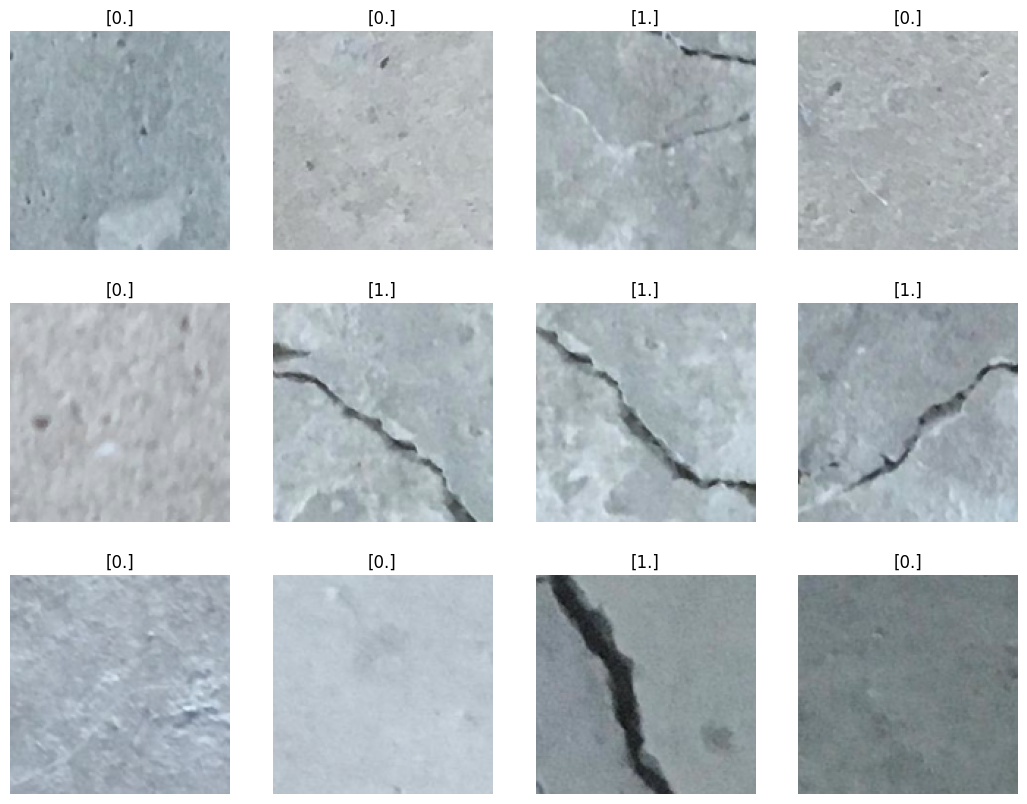

In [41]:
dataset = h5py.File(filename,'r')
images = dataset['images']
labels= dataset['meta']

plt.subplots(3,4,figsize = (13,10))
for i in range(12):
    img_np = images[i]
    plt.subplot(3,4,1+i)
    plt.imshow(img_np/255)
    plt.title(labels[i])
    plt.axis('off')
plt.show()

# Splitting dataset

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images[0:200], labels[0:200], test_size=0.2, random_state=1)

In [16]:
X_train /= 255
X_test /= 255

In [17]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
print('Training images: ', len(X_train))
print('Training labels: ', y_train.shape)

print('\nValidation images: ', len(X_test))
print('Validation labels: ', y_test.shape)


Training images:  160
Training labels:  (160, 2)

Validation images:  40
Validation labels:  (40, 2)


# Neural Network

Model selection, there are 3 models available.

In [19]:
# BASELINE
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
'''# VGG16

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
vgg.summary()

for layer in vgg.layers:
    layer.trainable=False

x = Flatten()(vgg.output)
x = Dense(512,activation='relu')(x)
x = Dense(512,activation='relu')(x)
prediction = Dense(2,activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()'''

In [ ]:
'''from tensorflow.keras.applications import ResNet50
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3))
resnet.summary()

for layer in resnet.layers:
    layer.trainable=False

x = Flatten()(resnet.output)
x = Dense(512,activation='relu')(x)
x = Dense(512,activation='relu')(x)
prediction = Dense(2,activation='sigmoid')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()'''

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=[
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True)])

# Saving Model

In [ ]:
model.save(hdf5_dir + 'modelo_concrete.h5')

## Model evaluation

In [20]:
def evaluate_model(model, x_test, y_test):
  loss, accuracy = model.evaluate(x_test, y_test,verbose=0)
  print('-------------------------------------------------------')
  print("Testing Loss: {:.5f}".format(loss))
  print("Testing Accuracy: {:.2f}".format(accuracy*100))
  print('-------------------------------------------------------\n')
  y_pred = model.predict(x_test, verbose=1)
  y_pred = np.argmax(y_pred, axis=1)
  
  cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
  cm = pd.DataFrame(cm)
  print('\n')
  clr =  classification_report(np.argmax(y_test, axis=1), y_pred, target_names=["Negative", "Positive"])
  print('-------------------------------------------------------')
  print('Confusion Matrix')
  print('-------------------------------------------------------')
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
  plt.yticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()
  print('\n-------------------------------------------------------')
  print('Classification Report:')
  print('-------------------------------------------------------')
  print(clr)
  return

-------------------------------------------------------
Testing Loss: 0.00144
Testing Accuracy: 100.00
-------------------------------------------------------

2/2 [==============================] - 1s 11ms/step


-------------------------------------------------------
Confusion Matrix
-------------------------------------------------------


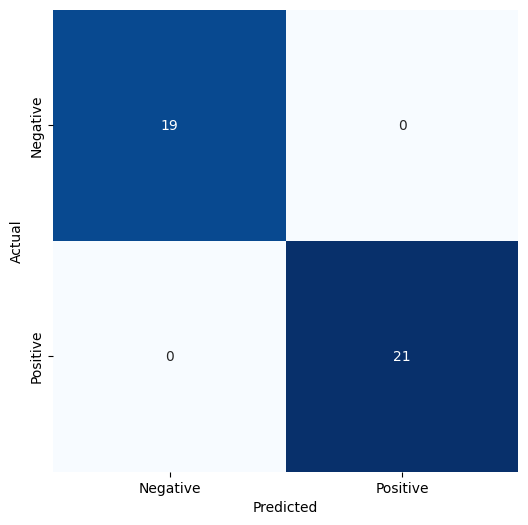


-------------------------------------------------------
Classification Report:
-------------------------------------------------------
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        19
    Positive       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [26]:
evaluate_model(model, X_test, y_test)

---
---

# TESTING: Real images

In [25]:
path_h5 = hdf5_dir /'modelo_concrete.h5'
model = load_model(path_h5)

In [28]:
def prediction(img):
  I = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255

  x = np.asarray(img).astype('float32')
  x = np.expand_dims(x, axis=0)
  x /= 255

  pred = model.predict(x, verbose=0)
  pred = np.argmax(pred, axis=1)

  if pred == 0:
      class_ = 'Negative'
  else:
      class_ = 'Postive'
      
  print('Prediction:', class_)
  plt.imshow(I)
  plt.axis('off')
  plt.show()
  
  return

### Loading real images

In [29]:
ruta_img = '/content/drive/MyDrive/Colab_Notebooks/DeepLearning/Datasets/Imagenes/'

Test1 = cv2.resize(cv2.imread(ruta_img+'grietas1.jpg'), (150, 150))
Test2 = cv2.resize(cv2.imread(ruta_img+'normal.jpg'), (150, 150))
Test3 = cv2.resize(cv2.imread(ruta_img+'grieta3.jfif'), (150, 150))
Test4 = cv2.resize(cv2.imread(ruta_img+'grieta4.jpg'), (150, 150))
Test5 = cv2.resize(cv2.imread(ruta_img+'normal1.jpg'), (150, 150))
Test6 = cv2.resize(cv2.imread(ruta_img+'normal2.jpg'), (150, 150))
Test7 = cv2.resize(cv2.imread(ruta_img+'normal3.jpg'), (150, 150))
Test8 = cv2.resize(cv2.imread(ruta_img+'normal4.jpg'), (150, 150))

Prediction: Postive


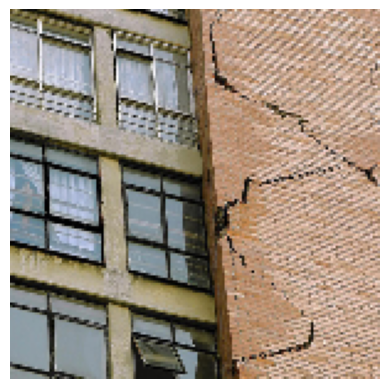

In [30]:
prediction(Test1)

Prediction: Negative


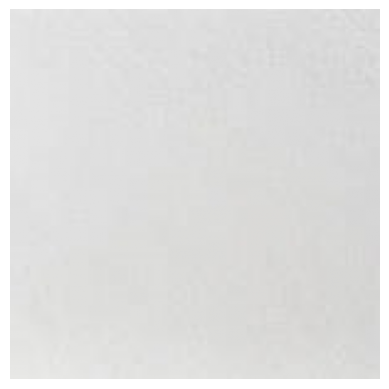

In [31]:
prediction(Test2)

Prediction: Postive


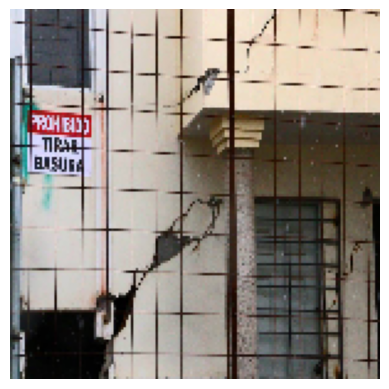

In [32]:
prediction(Test3)

Prediction: Postive


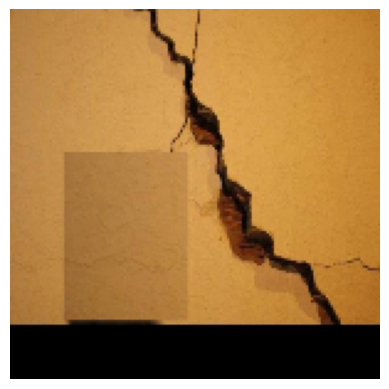

In [33]:
prediction(Test4)

Prediction: Postive


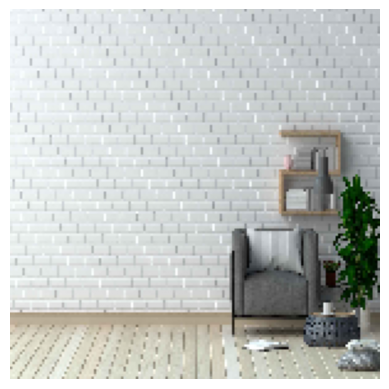

In [34]:
prediction(Test5)

Prediction: Negative


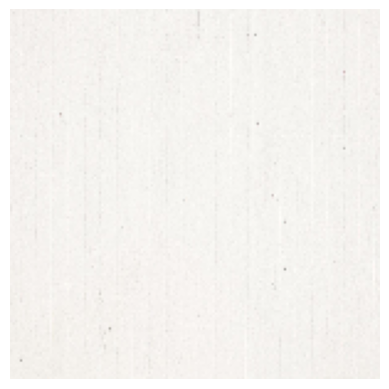

In [35]:
prediction(Test6)

Prediction: Postive


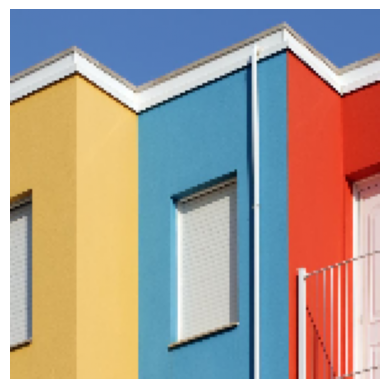

In [36]:
prediction(Test7)

Prediction: Postive


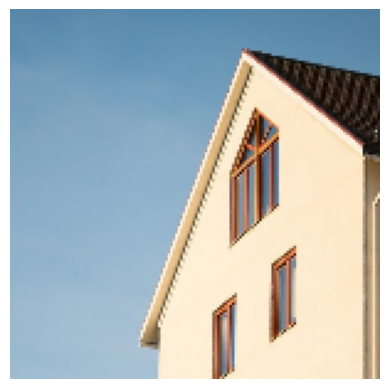

In [37]:
prediction(Test8)